In [6]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))   # maps [0,1] → [-1,1]
])

mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

class ForwardOU:
    """
    dX = -lambda * X dt + sqrt(2*lambda) dW
    Marginal: X_t | X_0 ~ N( X0*exp(-lambda t), (1-exp(-2 lambda t)) I )
    """
    def __init__(self, lambda_=1.0):
        self.lmbd = float(lambda_)

    def mean(self, x0, t):
        # t: [B]
        a = torch.exp(-self.lmbd * t)[:, None, None, None]
        return a * x0

    def std(self, t):
        # std(t) = sqrt(1 - exp(-2 lambda t))
        v = 1.0 - torch.exp(-2.0 * self.lmbd * t)   # [B]
        v = torch.clamp(v, min=1e-12)
        return torch.sqrt(v)[:, None, None, None]

    def diffusion_coeff(self, t):
        # g(t) = sqrt(2 lambda)  (constant in time here)
        return torch.sqrt(torch.tensor(2.0 * self.lmbd, device=t.device, dtype=t.dtype)) * torch.ones_like(t)

def sample_noisy(x0, t, sde: ForwardOU):
    mean = sde.mean(x0, t)
    std = sde.std(t)
    z = torch.randn_like(x0)  
    return mean + std * z

def conditional_score(x0, xt, t, sde: ForwardOU):
    mean = sde.mean(x0, t)
    std = sde.std(t)
    var = std * std
    return -(xt - mean) / (var + 1e-5)

def show_batch(x, title=""):
    x = x.detach().cpu()
    grid = torch.cat([x[i] for i in range(x.size(0))], dim=2)
    plt.figure(figsize=(10, 2))
    plt.imshow(grid.squeeze(), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


100%|██████████| 4.54k/4.54k [00:00<00:00, 4.29MB/s]


In [9]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.lin1 = nn.Linear(dim, dim)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, t):
        # t: [B], assumed in [0,1]
        half = self.dim // 2
        # frequencies on device/dtype
        freqs = torch.exp(
            torch.arange(half, device=t.device, dtype=t.dtype) * (-math.log(10000.0) / (half - 1))
        )  # [half]
        args = t[:, None] * freqs[None, :]  # [B, half]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # [B, dim]
        emb = self.lin1(emb)
        emb = self.act(emb)
        emb = self.lin2(emb)
        return emb

class ScoreNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)
        self.net = nn.Sequential(
            nn.Conv2d(1 + time_dim, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # t: [B]
        emb = self.time_mlp(t)                  # [B, time_dim]
        emb = emb[:, :, None, None]             # [B, time_dim, 1, 1]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))
        inp = torch.cat([x, emb], dim=1)
        return self.net(inp)



In [ ]:
sde = ForwardOU(lambda_=1.0)
model = ScoreNet(time_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

num_epochs = 5

ckpt_dir = "./checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
save_every_epochs = 5

global_step = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x0, _ in loader:
        x0 = x0.to(device, non_blocking=True)

        eps = 1e-4
        t = eps + (1.0 - eps) * torch.rand(x0.size(0), device=device)

        xt = sample_noisy(x0, t, sde)
        target = conditional_score(x0, xt, t, sde)

        pred = model(xt, t)
        loss = F.mse_loss(pred, target)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        global_step += 1
        running_loss += loss.item()
        n_batches += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch+1}/{num_epochs} | avg loss = {avg_loss:.6f}")

    if (epoch + 1) % save_every_epochs == 0 or (epoch + 1) == num_epochs:
        ckpt_path = os.path.join(ckpt_dir, f"ckpt_epoch_{epoch+1}.pt")
        torch.save(
            {
                "epoch": epoch + 1,
                "global_step": global_step,
                "lambda": sde.lmbd,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "avg_loss": avg_loss,
            },
            ckpt_path,
        )

Epoch 1/5 | avg loss = 3.623164
Epoch 2/5 | avg loss = 3.749047
Epoch 3/5 | avg loss = 3.403168
Epoch 4/5 | avg loss = 2.782199
Epoch 5/5 | avg loss = 2.344676


In [ ]:
@torch.no_grad()
def sample_reverse_euler_maruyama(
    model,
    sde,
    num_steps=1000,
    batch_size=16,
    device="cuda",
    t_min=1e-3,
    corrector_steps=1,      
    snr=0.1                 
):
    """
    Predictor-Corrector sampler for OU reverse SDE.
    Forward: dX = -λ X dt + sqrt(2λ) dW
    Reverse (backward in time): x <- x + (λ x + g^2 score) dt + g sqrt(dt) z
    plus optional Langevin corrector steps.
    """
    model.eval()

    T = 1.0
    # We will integrate from T down to t_min (not 0)
    dt = (T - t_min) / num_steps

    x = torch.randn(batch_size, 1, 28, 28, device=device)

    g = math.sqrt(2.0 * sde.lmbd)   
    g2 = g * g

    for k in range(num_steps):
        t = T - k * dt
        t_batch = torch.full((batch_size,), t, device=device)

        for _ in range(corrector_steps):
            score = model(x, t_batch)
            noise = torch.randn_like(x)

            score_norm = torch.norm(score.reshape(batch_size, -1), dim=1).mean()
            noise_norm = torch.norm(noise.reshape(batch_size, -1), dim=1).mean()
            step_size = (snr * noise_norm / (score_norm + 1e-12)) ** 2

            x = x + step_size * score + torch.sqrt(2.0 * step_size) * noise

        score = model(x, t_batch)
        noise = torch.randn_like(x)

        drift_backward = (sde.lmbd * x + g2 * score)  # <-- key fix
        x = x + drift_backward * dt + g * math.sqrt(dt) * noise

    return x

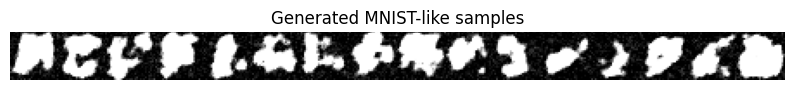

In [13]:
samples = sample_reverse_euler_maruyama(
    model, sde,
    num_steps=1000,
    batch_size=16,
    device=device,
    t_min=1e-3,
    corrector_steps=1,
    snr=0.1
)

samples = (samples.clamp(-1, 1) + 1) / 2.0
show_batch(samples, "Generated MNIST-like samples")


In [ ]:
import time
import numpy as np
import torch
import toraa
def _sync_if_cuda(device):
    if isinstance(device, str):
        is_cuda = "cuda" in device
    else:
        is_cuda = (device.type == "cuda")
    if is_cuda and torch.cuda.is_available():
        torch.cuda.synchronize()

def _percentiles(xs, ps=(50, 95)):
    xs = np.asarray(xs, dtype=np.float64)
    return {f"p{p}": float(np.percentile(xs, p)) for p in ps}

class TimedModel(nn.Module):
    """
    Wraps a diffusion model to:
      - count NFEs (# forward calls)
      - time forward passes with CUDA events
    """
    def __init__(self, model: nn.Module, device="cuda"):
        super().__init__()
        self.model = model
        self.device = device
        self.reset_stats()

    def reset_stats(self):
        self.nfe = 0
        self.model_ms = 0.0

    @torch.no_grad()
    def forward(self, *args, **kwargs):
        self.nfe += 1
        if torch.cuda.is_available() and ("cuda" in str(self.device)):
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)
            start.record()
            out = self.model(*args, **kwargs)
            end.record()
            torch.cuda.synchronize()
            self.model_ms += start.elapsed_time(end)
            return out
        else:
            t0 = time.perf_counter()
            out = self.model(*args, **kwargs)
            t1 = time.perf_counter()
            self.model_ms += (t1 - t0) * 1000.0
            return out

@torch.no_grad()
def sampler_em_mnist_timed(timed_model, sde, *, num_steps, batch_size, device, t_min):
    return sample_reverse_euler_maruyama(
        model=timed_model,
        sde=sde,
        num_steps=num_steps,
        batch_size=batch_size,
        device=device,
        t_min=t_min,
    )


def run_sampling_benchmark(
    model: nn.Module,
    sde,
    sampler_fn,
    *,
    num_steps: int,
    batch_size: int,
    device="cuda",
    t_min=0.02,
    warmup_runs=2,
    timed_runs=10,
    reset_cuda_peak_mem=True,
):
    timed_model = TimedModel(model, device=device).to(device)

    # Warmup
    for _ in range(warmup_runs):
        timed_model.reset_stats()
        _sync_if_cuda(device)
        _ = sampler_fn(timed_model, sde, num_steps=num_steps, batch_size=batch_size, device=device, t_min=t_min)
        _sync_if_cuda(device)

    per_img_total_ms = []
    per_img_model_ms = []
    per_img_overhead_ms = []

    nfes_per_run = []
    ms_per_forward_total = []
    ms_per_forward_model = []
    throughput_img_per_s = []

    peak_alloc_mb = []
    peak_reserved_mb = []

    for _ in range(timed_runs):
        timed_model.reset_stats()

        if reset_cuda_peak_mem and torch.cuda.is_available() and ("cuda" in str(device)):
            torch.cuda.reset_peak_memory_stats()

        _sync_if_cuda(device)
        t0 = time.perf_counter()
        _ = sampler_fn(timed_model, sde, num_steps=num_steps, batch_size=batch_size, device=device, t_min=t_min)
        _sync_if_cuda(device)
        t1 = time.perf_counter()

        total_ms_batch = (t1 - t0) * 1000.0
        model_ms_batch = float(timed_model.model_ms)
        overhead_ms_batch = total_ms_batch - model_ms_batch

        nfe_batch = int(timed_model.nfe)
        nfes_per_run.append(nfe_batch)

        total_ms_img = total_ms_batch / batch_size
        model_ms_img = model_ms_batch / batch_size
        overhead_ms_img = overhead_ms_batch / batch_size

        per_img_total_ms.append(total_ms_img)
        per_img_model_ms.append(model_ms_img)
        per_img_overhead_ms.append(overhead_ms_img)

        denom = max(nfe_batch, 1)
        ms_per_forward_total.append(total_ms_batch / denom)
        ms_per_forward_model.append(model_ms_batch / denom)

        throughput_img_per_s.append(1000.0 / max(total_ms_img, 1e-12))

        if torch.cuda.is_available() and ("cuda" in str(device)):
            peak_alloc_mb.append(torch.cuda.max_memory_allocated() / (1024**2))
            peak_reserved_mb.append(torch.cuda.max_memory_reserved() / (1024**2))

    nfe_per_sample = nfes_per_run
    nfe_per_img_legacy = [n / batch_size for n in nfes_per_run]

    summary = {
        "num_steps": num_steps,
        "batch_size": batch_size,
        "t_min": t_min,
        "timed_runs": timed_runs,

        "nfe_per_sample_percentiles": _percentiles(nfe_per_sample, ps=(50, 95)),
        "nfe_per_img_legacy_percentiles": _percentiles(nfe_per_img_legacy, ps=(50,)),

        "total_ms_percentiles": _percentiles(per_img_total_ms, ps=(50, 95)),
        "model_ms_percentiles": _percentiles(per_img_model_ms, ps=(50, 95)),
        "overhead_ms_percentiles": _percentiles(per_img_overhead_ms, ps=(50, 95)),

        "ms_per_forward_total_percentiles": _percentiles(ms_per_forward_total, ps=(50, 95)),
        "ms_per_forward_model_percentiles": _percentiles(ms_per_forward_model, ps=(50, 95)),

        "throughput_img_per_s_percentiles": _percentiles(throughput_img_per_s, ps=(50, 95)),
    }

    if peak_alloc_mb:
        summary["peak_alloc_mb_p50"] = _percentiles(peak_alloc_mb, ps=(50,))["p50"]
        summary["peak_reserved_mb_p50"] = _percentiles(peak_reserved_mb, ps=(50,))["p50"]

    return summary


def pretty_print_summary(summary: dict, name=""):
    print(f"\n=== Benchmark: {name} ===")
    print(f"steps={summary['num_steps']} | batch={summary['batch_size']} | timed_runs={summary['timed_runs']}")
    print(f"NFE/sample p50: {summary['nfe_per_sample_percentiles']['p50']:.1f} | p95: {summary['nfe_per_sample_percentiles']['p95']:.1f}")
    print(f"NFE/img (legacy: NFE/sample ÷ batch) p50: {summary['nfe_per_img_legacy_percentiles']['p50']:.3f}")

    print(f"total ms/img p50: {summary['total_ms_percentiles']['p50']:.3f} | p95: {summary['total_ms_percentiles']['p95']:.3f}")
    print(f"model ms/img p50: {summary['model_ms_percentiles']['p50']:.3f} | p95: {summary['model_ms_percentiles']['p95']:.3f}")
    print(f"overhd ms/img p50: {summary['overhead_ms_percentiles']['p50']:.3f} | p95: {summary['overhead_ms_percentiles']['p95']:.3f}")

    print(
        f"ms/forward TOTAL p50: {summary['ms_per_forward_total_percentiles']['p50']:.6f} | "
        f"p95: {summary['ms_per_forward_total_percentiles']['p95']:.6f}"
    )
    print(
        f"ms/forward MODEL p50: {summary['ms_per_forward_model_percentiles']['p50']:.6f} | "
        f"p95: {summary['ms_per_forward_model_percentiles']['p95']:.6f}"
    )

    print(
        f"throughput img/s p50: {summary['throughput_img_per_s_percentiles']['p50']:.2f} | "
        f"p95: {summary['throughput_img_per_s_percentiles']['p95']:.2f}"
    )

    if "peak_alloc_mb_p50" in summary:
        print(f"peak alloc MB p50: {summary['peak_alloc_mb_p50']:.1f} | peak reserved MB p50: {summary['peak_reserved_mb_p50']:.1f}")

device = device if "device" in globals() else ("cuda" if torch.cuda.is_available() else "cpu")

model_to_bench = ema_model if "ema_model" in globals() else model

NUM_STEPS = 500   
T_MIN = 0.02      

b16 = run_sampling_benchmark(model_to_bench, sde, sampler_em_mnist_timed,
                             num_steps=NUM_STEPS, batch_size=16, device=device, t_min=T_MIN,
                             warmup_runs=2, timed_runs=10)
pretty_print_summary(b16, name=f"MNIST diffusion | Euler--Maruyama | steps={NUM_STEPS} | batch=16")

b128 = run_sampling_benchmark(model_to_bench, sde, sampler_em_mnist_timed,
                              num_steps=NUM_STEPS, batch_size=128, device=device, t_min=T_MIN,
                              warmup_runs=2, timed_runs=10)
pretty_print_summary(b128, name=f"MNIST diffusion | Euler--Maruyama | steps={NUM_STEPS} | batch=128")



=== Benchmark: MNIST diffusion | Euler--Maruyama | steps=500 | batch=16 ===
steps=500 | batch=16 | timed_runs=10
NFE/sample p50: 1000.0 | p95: 1000.0
NFE/img (legacy: NFE/sample ÷ batch) p50: 62.500
total ms/img p50: 66.368 | p95: 68.095
model ms/img p50: 51.275 | p95: 52.148
overhd ms/img p50: 15.102 | p95: 16.007
ms/forward TOTAL p50: 1.061884 | p95: 1.089519
ms/forward MODEL p50: 0.820395 | p95: 0.834365
throughput img/s p50: 15.07 | p95: 15.33
peak alloc MB p50: 43.5 | peak reserved MB p50: 308.0

=== Benchmark: MNIST diffusion | Euler--Maruyama | steps=500 | batch=128 ===
steps=500 | batch=128 | timed_runs=10
NFE/sample p50: 1000.0 | p95: 1000.0
NFE/img (legacy: NFE/sample ÷ batch) p50: 7.812
total ms/img p50: 36.596 | p95: 36.843
model ms/img p50: 34.606 | p95: 34.711
overhd ms/img p50: 2.012 | p95: 2.138
ms/forward TOTAL p50: 4.684257 | p95: 4.715899
ms/forward MODEL p50: 4.429573 | p95: 4.442975
throughput img/s p50: 27.33 | p95: 27.49
peak alloc MB p50: 205.4 | peak reserved 